<h1><center>COURSE PROJECT</center></h1>


***Task***: Write a program that generates Van der Waals Isotherm plots of a gas including the region of phase coexistence using Maxwell construction  

The van der Waals EOS is :

<center> $\bigl(p + \frac{a}{V^2}\bigr)(V-b)=RT$ </center>

<center>$\big(p + \frac{an^2}{V^2}\big)(V - nb)$</center>

In the $pV$-plane, the dependence between pressure and volume at $t=const$ is represented as a family of isotherms, each of which corresponds to a certain temperature. To investigate this dependency in more detail, we transform the Van der Waals equation to the following form. The equation of an isotherm in the Van der Waals model can be written as

<center>$p(V)= \frac{RT}{V-b} - \frac{a}{V^2}$</center>

from that equation,  we obtain:
<center>$pV^3 - (pb +RT)V^2 + aV -ab = 0$</center>

<center>$ v^3 - \big(\frac{p +8t}{3p}\big)v^2+ \big(\frac{3}{p}\big)v- \frac{1}{p}$</center>

This cubic equation has 1 or 3 real roots 

In [29]:
import numpy as np
from numpy.linalg import eigvals
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.signal import  argrelmin,argrelmax
from cycler import cycler



%matplotlib inline 

In [33]:
# Define the reduced form of the Van der Waals equation of state
def vdw(vr,tr):
    """Van der Waals reduced equation of state.

    Return the reduced pressure from the reduced volume and temperature.
    
    """
    pr= (8.*tr)/(3.*vr-1.) -3./(vr**2.)
    return pr

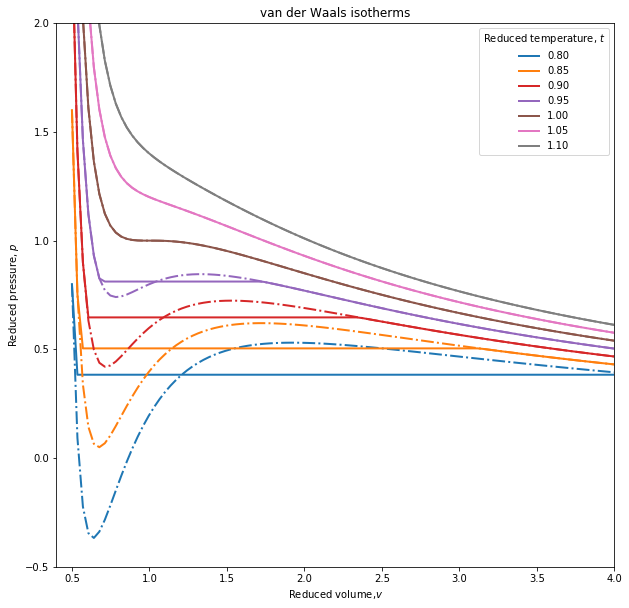

In [35]:
def vdw_max(vr,tr):
    """Van der Waals equation of state with Maxwell construction.
    
    Return the reduced pressure from the reduced temperature and volume,
    applying the Maxwell construction correction to the  region of coexistence of phase
    if necessary.
    """
    
    pr = vdw(vr,tr)
    
    if tr >= 1: # Coexistence of phase does not exist above the critical temperature
        return pr
    
    # 
    # Make initial guess for the position of Maxwell construction line:
    # We need to guess the middle root of the equation.
    # So the Idea is to take the average of the two extrema(the min point and max point) and draw the initial max 
    # construction through this point
    
    prmin = argrelmin(pr)    #Calculate the relative minima of data.
    prmax = argrelmax(pr)    #Calculate the relative maxima of data.
    
    vr1 = np.mean([vr[prmin], vr[prmax]])  # Middle root is the average of the max and min
    
    def get_extr_vol(pr1):
        """Solve the transformed van der Waals equation for reduced volume.
        
        Return the lowest and highest reduced volumes when  the reduced
        pressure is pr1
        """
        vdw_eos=np.asarray([[0, 0 , 1/pr1],
                         [1, 0 , -3.0 / pr1],
                         [0, 1 , 1. / 3.0 * (1.0 + 8.0 * tr / pr1)]])
        
        roots= eigvals(vdw_eos)
#         vdw_eos = [1.0, -1. / 3.0 * (1.0 + 8.0 * tr / pr1), 3.0 / pr1, - 1.0 / pr1]
#         roots = np.roots(vdw_eos)
#         roots.sort()
        vr0,_,vr2 = roots
        
        return vr0,vr2
    
    def get_area_diff(vr1):
        """Return the difference in areas of the van der Waals loops.
        
        Computes the difference in area between the isotherm and the maxwell contruction line in each loop.
        The areas should be equal if the line is a maxwell construction(difference should be zero)
        """
        pr1 = vdw(vr1,tr)
        vr0,vr2 = get_extr_vol(pr1)
        
        
        return quad(lambda vr:vdw(vr,tr)-pr1,vr0,vr2)[0]
        
            
    # Use Newton's method to finetune the initial approximation of the middle root
    # Performs iteration to get a more exact value of v1
    vr1 = newton(get_area_diff,vr1)
    pr1 = vdw(vr1,tr)
    vr0,vr2 = get_extr_vol(pr1)
    pr[(vr>=vr0) & (vr<=vr2)]= pr1
    
    A1= quad(lambda vr:pr1 - vdw(vr,tr),vr0,vr1)[0]
    A2= quad(lambda vr:vdw(vr,tr)- pr1,vr1,vr2)[0]
    error = abs(A2-A1)
    
#     print ('Maxwell contruction:',pr1)
#     print ('==========================')     
#     print ('First area:', A1 )
#     print ('Second area:',A2 )
#     print ('Error:',error )
#     print ('\n')
    
    return pr

   
        


vr= np.linspace(0.5, 4, 100)

color = iter(['C0', 'C1', 'C3', 'C4', 'C5','C6','C7','C8'])

fig, ax = plt.subplots(figsize=(10,10));



for tr in np.asarray([0.8,0.85,0.9,0.95,1.0,1.05,1.1]) :
    c= next(color)
    ax.plot(vr, vdw(vr, tr), lw=2, color=c, linestyle='-.');

    ax.plot(vr, vdw_max(vr, tr), lw=2, label='{:.2f}'.format(tr), color=c);

    

    
ax.set_xlim(0.4, 4.)
ax.set_xlabel('Reduced volume,$v$ ')
ax.set_ylim(-.5, 2.)
ax.set_ylabel('Reduced pressure, $p$')    
ax.legend(title='Reduced temperature, $t$')
plt.title('van der Waals isotherms')

plt.show();
    
         


        